Json bien structuré

In [1]:
import requests
import time
import sys
from typing import Union, List, Dict, Any, Optional


class RedditScraper:
    """
    A simple class to fetch subreddit posts and comments from Reddit's
    (mostly) public JSON endpoints. Suitable for small-scale or personal
    usage. For production or large-scale usage, switch to an OAuth-based
    approach (e.g., PRAW).
    """

    def __init__(
        self,
        user_agent: str = "MyRedditApp/1.0 (by u/my_username)",
        max_pages: int = 2,
        sleep_time: float = 2.0
    ):
        """
        Initialize the RedditScraper.

        :param user_agent: Custom User-Agent string to identify your client.
        :param max_pages: Default number of 'pages' to paginate for posts.
        :param sleep_time: Pause (in seconds) between page fetches to avoid rate-limits.
        """
        self.user_agent = user_agent
        self.headers = {"User-Agent": self.user_agent}
        self.max_pages = max_pages
        self.sleep_time = sleep_time

    # ---------------------------------------------------------------------
    # (A) Fetching Subreddit Posts
    # ---------------------------------------------------------------------
    def fetch_subreddit_posts(
        self,
        subreddits: Union[str, List[str]],
        sort: str = "new",
        limit: int = 25,
        max_pages: Optional[int] = None,
        time_filter: Optional[str] = None
    ) -> Dict[str, List[Dict[str, Any]]]:
        """
        Fetch posts from one or more subreddits. Supports pagination and time filtering.

        :param subreddits: A single subreddit (string) or list of subreddit names.
        :param sort: Sorting criterion (e.g., "new", "hot", "top", "rising", "controversial").
        :param limit: Number of posts to fetch per request (max ~100).
        :param max_pages: How many pages to fetch. Defaults to self.max_pages if None.
        :param time_filter: Time filter (valid if sort="top" or "controversial"), 
                            e.g., "day", "week", "month", "year".
        :return: Dictionary where key=subreddit, value=list of post data dicts.
        """
        if isinstance(subreddits, str):
            subreddits = [subreddits]  # Wrap in a list for uniform processing

        if max_pages is None:
            max_pages = self.max_pages

        results = {}
        for subreddit in subreddits:
            all_posts = []
            after = None

            for page in range(max_pages):
                print(f"Fetching page {page + 1} from r/{subreddit} ({sort}), time_filter={time_filter} ...")
                page_data = self._fetch_subreddit_page(
                    subreddit=subreddit,
                    sort=sort,
                    limit=limit,
                    after=after,
                    time_filter=time_filter
                )

                if not page_data:
                    # Something went wrong, or no posts returned
                    break

                all_posts.extend(page_data["posts"])
                after = page_data["after"]

                if not after:
                    # No more pagination
                    break

                # Sleep to respect rate limits
                time.sleep(self.sleep_time)

            results[subreddit] = all_posts

        return results

    # ---------------------------------------------------------------------
    # (B) Fetching Comments for a Specific Post
    # ---------------------------------------------------------------------
    def fetch_comments_for_post(
        self,
        subreddit: str,
        post_id: str
    ) -> List[Dict[str, Any]]:
        """
        Fetch comments for a specific post in a subreddit.
        (Does not apply comment depth limitation here; see 'posts_and_comments_to_text'
         or your own logic to limit levels if needed.)

        :param subreddit: Subreddit name (e.g., "python").
        :param post_id: The base-36 ID of the post (e.g. "abc123").
        :return: List of parsed comments, including nested replies.
                 Note: Includes *all* comment levels. You may filter later if desired.
        """
        url = f"https://www.reddit.com/r/{subreddit}/comments/{post_id}.json"
        print(f"Fetching comments for post {post_id} in r/{subreddit} ...")

        try:
            response = requests.get(url, headers=self.headers)
        except requests.exceptions.RequestException as e:
            print(f"Request error: {e}")
            return []

        if response.status_code != 200:
            print(f"Error: HTTP {response.status_code} for {url}")
            return []

        try:
            data = response.json()
        except ValueError:
            print("Error parsing JSON response.")
            return []

        # data[0] is post info, data[1] is the comment listing
        if len(data) < 2:
            return []

        comments_root = data[1]
        comments_list = comments_root.get("data", {}).get("children", [])
        parsed_comments = []

        for comment in comments_list:
            if comment.get("kind") == "t1":  # 't1' = comment
                parsed_comments.append(self._parse_comment(comment))

        return parsed_comments

    # ---------------------------------------------------------------------
    # (C) Fetching Both Posts and Comments (Subreddit-level)
    # ---------------------------------------------------------------------
    def fetch_posts_and_comments(
        self,
        subreddits: Union[str, List[str]],
        sort: str = "new",
        limit: int = 25,
        max_pages: Optional[int] = None,
        time_filter: Optional[str] = None
    ) -> Dict[str, List[Dict[str, Any]]]:
        """
        Convenience method to fetch posts from one or multiple subreddits,
        and then fetch comments for each post. Returns a fully nested structure.

        :param subreddits: A single subreddit (string) or list of subreddit names.
        :param sort: Sorting criterion (e.g., "new", "hot", "top", "rising", "controversial").
        :param limit: Number of posts to fetch per request.
        :param max_pages: How many pages to fetch (for each subreddit).
        :param time_filter: Time filter (valid if sort="top" or "controversial"), e.g., "day", "week", etc.
        :return: {
            "<subreddit>": [
                {
                    "id": <post_id>,
                    "title": "...",
                    "selftext": "...",
                    "comments": [ ... list of comments ... ],
                    ...
                },
                ...
            ],
            ...
        }
        """
        posts_dict = self.fetch_subreddit_posts(
            subreddits=subreddits,
            sort=sort,
            limit=limit,
            max_pages=max_pages,
            time_filter=time_filter
        )

        # Now, fetch comments for each post
        for subreddit, posts_list in posts_dict.items():
            for post_data in posts_list:
                post_id = post_data.get("id")
                if post_id:
                    comments = self.fetch_comments_for_post(subreddit, post_id)
                    post_data["comments"] = comments
                else:
                    post_data["comments"] = []

        return posts_dict

    # ---------------------------------------------------------------------
    # (D) Searching Within a Single Subreddit
    # ---------------------------------------------------------------------
    def search_subreddit_posts(
        self,
        subreddit: str,
        query: str,
        sort: str = "relevance",
        time_filter: Optional[str] = None,
        limit: int = 25
    ) -> List[Dict[str, Any]]:
        """
        Search a specific subreddit for posts matching a given query.

        :param subreddit: The name of the subreddit (e.g., "python").
        :param query: The search query string (e.g., "web scraping").
        :param sort: One of ['relevance', 'hot', 'top', 'new', 'comments'].
        :param time_filter: Filter posts by time ('hour', 'day', 'week', 'month', 'year', 'all').
        :param limit: Number of posts to fetch in one request (up to ~100).
        :return: A list of post data dicts.
        """
        base_url = f"https://www.reddit.com/r/{subreddit}/search.json"
        params = {
            "q": query,
            "restrict_sr": "1",   # search only in this subreddit
            "sort": sort,
            "limit": limit
        }
        if time_filter:
            params["t"] = time_filter

        try:
            response = requests.get(base_url, headers=self.headers, params=params)
        except requests.exceptions.RequestException as e:
            print(f"Request error: {e}")
            return []

        if response.status_code != 200:
            print(f"Error: HTTP {response.status_code} for {base_url}")
            return []

        try:
            data = response.json()
        except ValueError:
            print("Error parsing JSON.")
            return []

        posts = []
        children = data.get("data", {}).get("children", [])
        for child in children:
            if child.get("kind") == "t3":
                post_info = child.get("data", {})
                posts.append(post_info)

        return posts

    # ---------------------------------------------------------------------
    # (E) Global (All-Reddit) Keyword Search
    # ---------------------------------------------------------------------
    def global_reddit_search(
        self,
        query: str,
        limit: int = 25,
        sort: str = "relevance",
        time_filter: str = "all",
        after: Optional[str] = None
    ) -> Optional[Dict[str, Any]]:
        """
        Perform a keyword search across ALL of Reddit (unauthenticated).

        :param query: The search query (string).
        :param limit: Number of search results to fetch (max ~100 per request).
        :param sort: Sorting criterion: "relevance", "hot", "top", "new", "comments".
        :param time_filter: Time filter: "hour", "day", "week", "month", "year", "all".
        :param after: Pagination token for the next set of results.
        :return: A dict with 'results' (list of posts) and 'after' (token to get next page),
                 or None if an error occurs.
        """
        base_url = "https://www.reddit.com/search.json"
        params = {
            "q": query,
            "limit": limit,
            "sort": sort,
            "t": time_filter
        }
        if after:
            params["after"] = after

        try:
            response = requests.get(base_url, headers=self.headers, params=params)
        except requests.exceptions.RequestException as e:
            print(f"Request error: {e}")
            return None

        if response.status_code != 200:
            print(f"Error: HTTP {response.status_code}")
            return None

        try:
            data = response.json()
        except ValueError:
            print("Error parsing JSON.")
            return None

        children = data.get("data", {}).get("children", [])
        results = []

        for child in children:
            if child.get("kind") == "t3":  # 't3' means it's a post
                post_data = child.get("data", {})
                results.append(post_data)

        after_token = data.get("data", {}).get("after", None)
        return {"results": results, "after": after_token}

    # ---------------------------------------------------------------------
    # (F) Search by Keywords, Fetch Comments, Return in Single Structure
    # ---------------------------------------------------------------------
    def search_keywords_and_get_posts_comments(
        self,
        query: str,
        limit: int = 25,
        sort: str = "relevance",
        time_filter: str = "all"
    ) -> List[Dict[str, Any]]:
        """
        Global search by keywords, then fetch comments for each post. 
        Returns a list of post dicts, each including "comments".

        :param query: The search query.
        :param limit: Max results (per fetch). For large numbers, consider paging.
        :param sort: "relevance", "hot", "top", "new", "comments".
        :param time_filter: "hour", "day", "week", "month", "year", "all".
        :return: A list of posts, each with a nested "comments" field.
        """
        print(f"Performing global search for '{query}', limit={limit}, sort={sort}, time_filter={time_filter}")
        # 1) Perform a single global search call (no pagination here; you can extend if needed).
        search_result = self.global_reddit_search(
            query=query,
            limit=limit,
            sort=sort,
            time_filter=time_filter
        )
        if not search_result:
            return []

        posts = search_result.get("results", [])
        # 2) For each post, fetch comments by subreddit/post_id
        for post in posts:
            subr = post.get("subreddit")
            pid = post.get("id")
            if subr and pid:
                # Fetch comments for each post
                comments = self.fetch_comments_for_post(subr, pid)
                post["comments"] = comments
            else:
                post["comments"] = []

        return posts

    # ---------------------------------------------------------------------
    # (G) Convert Posts (and Nested Comments) to a Single Text String
    # ---------------------------------------------------------------------
    def posts_and_comments_to_text(
        self,
        posts_data: List[Dict[str, Any]],
        max_comment_level: int = 999
    ) -> str:
        """
        Flatten/serialize a list of post dicts (each with nested comments)
        into a single large text string for easier saving or processing.

        :param posts_data: A list of post dicts, each with optional "comments" array.
        :param max_comment_level: The maximum depth of comment nesting to include.
                                  0 means no comments, 1 = only top-level, etc.
        :return: A single text string containing posts & comments.
        """
        lines = []
        for i, post in enumerate(posts_data, start=1):
            title = post.get("title", "[No Title]")
            selftext = post.get("selftext", "")
            lines.append(f"=== Post #{i} ===")
            lines.append(f"Title: {title}")
            lines.append(f"Body: {selftext}")

            # Convert comments to text, respecting max_comment_level
            comments_list = post.get("comments", [])
            if max_comment_level > 0 and comments_list:
                lines.append(f"--- Comments (Up to level {max_comment_level}) ---")
                for comment_str in self._flatten_comment_text(
                        comments_list, 
                        current_level=1, 
                        max_level=max_comment_level):
                    lines.append(comment_str)
            else:
                lines.append("--- No Comments (or Comments Suppressed) ---")

            lines.append("\n")  # Blank line after each post

        return "\n".join(lines)

    def _flatten_comment_text(
        self,
        comments: List[Dict[str, Any]],
        current_level: int,
        max_level: int
    ) -> List[str]:
        """
        Recursively flatten comment trees into a list of strings, respecting max_level.
        Skips comments where author="[deleted]" or body="[removed]".

        :param comments: List of comment dicts (each may have 'replies').
        :param current_level: Current nesting level in the comment tree.
        :param max_level: The maximum nesting level to include.
        :return: A list of comment lines (strings).
        """
        lines = []
        if current_level > max_level:
            return lines  # stop if we've exceeded desired depth

        indent = "  " * current_level  # Indentation for readability
        for c in comments:
            body = c.get("body", "[No text]")
            author = c.get("author", "[unknown]")
            if author == "[deleted]" or body == "[removed]":
                # Skip comments that are effectively removed or deleted
                continue

            # Include this comment
            lines.append(f"{indent}- (level {current_level}) Comment by {author}: {body}")

            replies = c.get("replies", [])
            if replies:
                # Recurse deeper if we haven't exceeded max_level
                lines.extend(
                    self._flatten_comment_text(
                        replies, 
                        current_level=current_level + 1, 
                        max_level=max_level
                    )
                )
        return lines

    # ---------------------------------------------------------------------
    #   Internal Helper Methods for Subreddit Pages & Parsing Comments
    # ---------------------------------------------------------------------
    def _fetch_subreddit_page(
        self,
        subreddit: str,
        sort: str,
        limit: int,
        after: Optional[str],
        time_filter: Optional[str]
    ) -> Optional[Dict[str, Any]]:
        """
        Fetch a single "page" (one HTTP request) of subreddit posts.
        Returns None if an error occurs or no data.

        :param subreddit: Name of the subreddit (e.g., "python").
        :param sort: Sorting criterion (e.g., "new", "hot", "top", "rising").
        :param limit: Number of posts per request (max ~100).
        :param after: Pagination token for next page.
        :param time_filter: Time filter if sort="top" or "controversial" (e.g. "day", "week", "month").
        """
        base_url = f"https://www.reddit.com/r/{subreddit}/{sort}.json"
        params = {"limit": limit}
        if after:
            params["after"] = after

        if time_filter:
            params["t"] = time_filter

        try:
            response = requests.get(base_url, headers=self.headers, params=params)
        except requests.exceptions.RequestException as e:
            print(f"Request error: {e}")
            return None

        if response.status_code != 200:
            print(f"Error: HTTP {response.status_code} for {base_url}")
            return None

        try:
            data = response.json()
        except ValueError:
            print("Error parsing JSON response.")
            return None

        children = data.get("data", {}).get("children", [])
        posts = []

        for child in children:
            if child.get("kind") == "t3":  # 't3' = post
                post_info = child.get("data", {})
                posts.append(post_info)

        after_token = data.get("data", {}).get("after", None)
        return {
            "posts": posts,
            "after": after_token
        }

    def _parse_comment(self, comment_obj: Dict[str, Any]) -> Dict[str, Any]:
        """
        Recursively parse a comment (and its replies) into a dictionary.
        (Does not skip "[deleted]" or "[removed]" here; skipping logic 
         is applied later in _flatten_comment_text.)
        """
        comment_data = comment_obj.get("data", {})
        comment_id = comment_data.get("id")
        comment_author = comment_data.get("author")
        comment_body = comment_data.get("body", "")
        created_utc = comment_data.get("created_utc", 0)

        # Recursively parse any replies
        replies_obj = comment_data.get("replies")
        nested_comments = []
        if isinstance(replies_obj, dict):  # sometimes 'replies' can be an empty string
            children = replies_obj.get("data", {}).get("children", [])
            for child in children:
                if child.get("kind") == "t1":
                    nested_comments.append(self._parse_comment(child))

        return {
            "comment_id": comment_id,
            "author": comment_author,
            "body": comment_body,
            "created_utc": created_utc,
            "replies": nested_comments,
        }


# ---------------------------------------------------------------------
# Example Usage / Test Cases
# ---------------------------------------------------------------------
if __name__ == "__main__":
    try:
        scraper = RedditScraper(
            user_agent="MyRedditApp/1.0 (by u/my_username)",
            max_pages=1,
            sleep_time=1.5
        )

        ##########
        print("=== Test 1: Single Subreddit (Fetch Posts Only) ===")
        single_sub_data = scraper.fetch_subreddit_posts(
            subreddits="NVDA_Stock",
            sort="top",
            time_filter="day",
            limit=3,
        )
        print(f"Fetched {len(single_sub_data['NVDA_Stock'])} posts from r/NVDA_Stock")
        for post in single_sub_data["NVDA_Stock"]:
            print(f" - {post.get('title')} (ID: {post.get('id')})")
        
        ##########
        print("\n=== Test 2: Multiple Subreddits (Fetch Posts + Comments) ===")
        multi_sub_data = scraper.fetch_posts_and_comments(
            subreddits=["nvidia", "NVDA_Stock"],
            sort="top",
            time_filter="day",
            limit=2,
            max_pages=1  # just 1 page each for brevity
        )
        for subr, posts in multi_sub_data.items():
            print(f"\nr/{subr}: {len(posts)} posts fetched.")
            for p in posts:
                print(f"  Title: {p.get('title')} => {len(p.get('comments', []))} comments")

        # ------------------------------------------
        # CORRECTION:
        # To generate combined text for ALL subreddits, first collect all posts in one list.
        # ------------------------------------------
        all_posts = []
        for subr, posts in multi_sub_data.items():
            all_posts.extend(posts)

        combined_text = scraper.posts_and_comments_to_text(all_posts, max_comment_level=2)
        print("\n--- Combined Text (Truncated for Demo) ---")
        print(combined_text[:1000], "... [TRUNCATED]")


        ##########
        print("\n=== Test 3: Single Subreddit Search ===")
        srch_results = scraper.search_subreddit_posts(
            subreddit="stocks",
            query="NVDA",
            sort="top",
            time_filter="week",
            limit=2
        )
        print(f"Found {len(srch_results)} posts in r/stocks about 'NVDA'")
        for i, post in enumerate(srch_results, start=1):
            print(f"   {i}. {post.get('title')} (score: {post.get('score')})")

        # You can flatten these search results into a single text as well:
        srch_text = scraper.posts_and_comments_to_text(srch_results, max_comment_level=2)
        print("\n--- Searched Posts Combined Text (Truncated) ---")
        print(srch_text[:1000], "... [TRUNCATED]")      


        ##########
        print("\n=== Test 4: Global Search ===")
        global_res = scraper.global_reddit_search(
            query="NVIDIA",
            limit=2,
            sort="relevance",
            time_filter="day"
        )
        if global_res:
            print(f"Fetched {len(global_res['results'])} global results about 'NVIDIA'")

        print("\n=== Test 5: Global Search, Fetch Comments, Flatten to Text (max_comment_level=2) ===")
        posts_with_comments = scraper.search_keywords_and_get_posts_comments(
            query="NVDA",
            limit=2,
            sort="relevance",
            time_filter="day"
        )
        
        # Now parse into a single text string, limiting to 2 levels of nested comments.
        final_text = scraper.posts_and_comments_to_text(posts_with_comments, max_comment_level=2)
        print("\n--- Final Combined Text (Truncated for Demo) ---")
        print(final_text[:1000], "... [TRUNCATED]")

    except KeyboardInterrupt:
        print("\nScript interrupted by user.")
        sys.exit(0)



=== Test 1: Single Subreddit (Fetch Posts Only) ===
Fetching page 1 from r/NVDA_Stock (top), time_filter=day ...
Fetched 3 posts from r/NVDA_Stock
 - Microsoft's $80B AI Bet: Data Center Expansion Fuels Nvidia and AMD Surge (ID: 1hsw4wz)
 - NVDA Swing Holdings 📈 (ID: 1hszsor)
 - The 1 Tech Stock That’s Actually a Bargain (ID: 1ht3qzo)

=== Test 2: Multiple Subreddits (Fetch Posts + Comments) ===
Fetching page 1 from r/nvidia (top), time_filter=day ...
Fetching page 1 from r/NVDA_Stock (top), time_filter=day ...
Fetching comments for post 1ht5avi in r/nvidia ...
Fetching comments for post 1hsq0jo in r/nvidia ...
Fetching comments for post 1hsw4wz in r/NVDA_Stock ...
Fetching comments for post 1hszsor in r/NVDA_Stock ...

r/nvidia: 2 posts fetched.
  Title: 4070 Ti Super build => 32 comments
  Title: 3090 to what? => 101 comments

r/NVDA_Stock: 2 posts fetched.
  Title: Microsoft's $80B AI Bet: Data Center Expansion Fuels Nvidia and AMD Surge => 7 comments
  Title: NVDA Swing Holdings 📈 

In [3]:
import re
import json
from typing import List, Dict, Optional

class RedditParser:
    def __init__(self, text: str):
        self.text = text
        self.posts = []

    def extract_comments(self, comment_section: str) -> List[Dict]:
        """
        Extract comments from a comment section.
        Returns a list of comment dictionaries with level, author, and content.
        """
        comments = []
        comment_pattern = r'\(level (\d+)\) Comment by (\w+): (.*?)(?=(?:\n  - \(level|\Z))'
        
        for match in re.finditer(comment_pattern, comment_section, re.DOTALL):
            level = int(match.group(1))
            author = match.group(2)
            content = self.clean_text(match.group(3))
            
            comment = {
                'level': level,
                'author': author,
                'content': content,
                'replies': []  # Will be populated for nested comments
            }
            comments.append(comment)

        # Organize comments into a tree structure
        comment_tree = []
        comment_stack = []
        
        for comment in comments:
            while comment_stack and comment['level'] <= comment_stack[-1]['level']:
                comment_stack.pop()
                
            if comment_stack:
                comment_stack[-1]['replies'].append(comment)
            else:
                comment_tree.append(comment)
                
            comment_stack.append(comment)

        return comment_tree

    def extract_posts(self) -> List[Dict]:
        """
        Extract posts and their comments from the text.
        Returns a list of dictionaries containing post information and comments.
        """
        # Split the text into sections based on "=== Post"
        post_sections = re.split(r'=== Post #\d+ ===', self.text)
        
        # Remove any empty sections
        post_sections = [section.strip() for section in post_sections if section.strip()]

        for section in post_sections:
            post_data = {}
            
            # Extract title
            title_match = re.search(r'Title: (.*?)(?:\nBody:|$)', section, re.DOTALL)
            if title_match:
                post_data['title'] = title_match.group(1).strip()

            # Extract body
            body_match = re.search(r'Body: (.*?)(?:---|\Z)', section, re.DOTALL)
            if body_match:
                post_data['body'] = body_match.group(1).strip()
            else:
                post_data['body'] = ""

            # Extract subreddit
            subreddit_match = re.search(r'(?:from|in) r/(\w+)', section)
            if subreddit_match:
                post_data['subreddit'] = subreddit_match.group(1)
            else:
                # If no subreddit found in the section, try to find it in the larger context
                subreddit_match = re.search(r'(?:from|in) r/(\w+)', self.text)
                if subreddit_match:
                    post_data['subreddit'] = subreddit_match.group(1)
                else:
                    post_data['subreddit'] = "unknown"

            # Extract comments
            comments_section_match = re.search(r'--- Comments \(Up to level \d+\) ---\n(.*?)(?=(?:\n===|\Z))', section, re.DOTALL)
            if comments_section_match:
                comments_text = comments_section_match.group(1)
                post_data['comments'] = self.extract_comments(comments_text)
            else:
                post_data['comments'] = []

            if post_data.get('title'):  # Only add if we at least have a title
                self.posts.append(post_data)

        return self.posts

    def clean_text(self, text: str) -> str:
        """Clean the text by removing extra whitespace and special characters."""
        if not text:
            return ""
        # Remove extra whitespace
        text = ' '.join(text.split())
        # Remove any special Reddit formatting
        text = re.sub(r'\[\w+\]|\(http[s]?://[^\)]+\)', '', text)
        return text.strip()

    def process_and_save(self) -> None:
        """
        Process the text and save the results to a JSON file.
        """
        # Extract and clean the posts
        posts = self.extract_posts()
        
        # Clean the text in each post
        for post in posts:
            post['title'] = self.clean_text(post['title'])
            post['body'] = self.clean_text(post['body'])

        # Save to JSON file
        # with open(output_file, 'w', encoding='utf-8') as f:
        #     json.dump({'posts': posts}, f, indent=2, ensure_ascii=False)
        
        return {
            'posts': posts
        }

def get_and_parse():
    # Read the input file
    # with open('output.txt', 'r', encoding='utf-8') as f:
    #     text = f.read()

    scraper = RedditScraper(
        user_agent="MyRedditApp/1.0 (by u/my_username)",
        max_pages=1,
        sleep_time=1.5
    )
    
    # Fetch posts and comments
    posts_with_comments = scraper.search_keywords_and_get_posts_comments(
            query="NVDA",
            limit=2,
            sort="relevance",
            time_filter="day"
    )
    # Combine posts and comments into a single text
    text = scraper.posts_and_comments_to_text(posts_with_comments, max_comment_level=2)

    # Create parser instance
    parser = RedditParser(text)
    
    text_parsed = parser.process_and_save()
    print(text_parsed)
    
    # Process and save to JSON
    # parser.process_and_save('reddit_posts.json')
    return text_parsed

if __name__ == "__main__":
    get_and_parse()

Performing global search for 'NVDA', limit=2, sort=relevance, time_filter=day
Fetching comments for post 1hswctz in r/wallstreetbets ...
Fetching comments for post 1hszsor in r/NVDA_Stock ...
{'posts': [{'title': '+$723k in NVDA 1DTE gains to start off the year', 'body': '', 'subreddit': 'unknown', 'comments': [{'level': 1, 'author': 'VisualMod', 'content': '**User Report**| | | | :--|:--|:--|:-- **Total Submissions** | 10 | **First Seen In WSB** | 4 years ago **Total Comments** | 718 | **Previous Best DD** | **Account Age** | 9 years | | [**Join WSB Discord**]', 'replies': []}, {'level': 1, 'author': 'discobr0', 'content': 'You put 133k in a 1DTE, something tells me this was peanuts to you anyway. - (level 2) Comment by Baraxton: It’s like bragging about winning at roulette. - (level 2) Comment by Cervix-Hammer: How do you even play 0dte calls? Like just by the option 1 day before expiry and hope it goes up? Does it typically have such massive gains 1dte? - (level 2) Comment by puppym

In [6]:
import json
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm

def get_sentiment_label(compound_score):
    """Convert compound score to sentiment label."""
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

def analyze_text(text, analyzer):
    """Analyze sentiment of a text using VADER."""
    scores = analyzer.polarity_scores(text)
    sentiment = get_sentiment_label(scores['compound'])
    return {
        'sentiment': sentiment,
        'scores': {
            'negative': scores['neg'],
            'neutral': scores['neu'],
            'positive': scores['pos'],
            'compound': scores['compound']
        }
    }

def analyze_comments(comments, analyzer):
    """Analyze comments recursively."""
    analyzed_comments = []
    
    for comment in comments:
        # Analyze current comment
        sentiment_result = analyze_text(comment['content'], analyzer)
        
        analyzed_comment = {
            'author': comment['author'],
            'content': comment['content'],
            'level': comment['level'],
            'sentiment': sentiment_result['sentiment'],
            'sentiment_scores': sentiment_result['scores']
        }
        
        # Analyze replies recursively
        if comment.get('replies'):
            analyzed_comment['replies'] = analyze_comments(comment['replies'], analyzer)
        else:
            analyzed_comment['replies'] = []
            
        analyzed_comments.append(analyzed_comment)
    
    return analyzed_comments

def process_data():
    print("Initializing VADER sentiment analyzer...")
    analyzer = SentimentIntensityAnalyzer()
    
    # Load Reddit data
    print("Loading Reddit data...")
    try:
        data = get_and_parse()
    except Exception as e:
        print(f"Error loading Reddit data: {str(e)}")
        return
    
    analyzed_posts = []
    
    # Process each post
    print("Analyzing posts and comments...")
    try:
        for post in tqdm(data['posts'], desc="Processing posts"):
            # Analyze post content
            post_text = f"{post['title']} {post['body']}"
            post_sentiment = analyze_text(post_text, analyzer)
            
            analyzed_post = {
                'subreddit': post['subreddit'],
                'title': post['title'],
                'body': post['body'],
                'sentiment': post_sentiment['sentiment'],
                'sentiment_scores': post_sentiment['scores']
            }
            
            # Analyze comments if present
            if post.get('comments'):
                analyzed_post['comments'] = analyze_comments(post['comments'], analyzer)
            else:
                analyzed_post['comments'] = []
                
            analyzed_posts.append(analyzed_post)
    except Exception as e:
        print(f"Error during analysis: {str(e)}")
        return
    
    # Save results
    try:
        print("Saving results...")
        # Save detailed analysis
        with open('sentiment_analysis.json', 'w', encoding='utf-8') as f:
            json.dump({'posts': analyzed_posts}, f, indent=2, ensure_ascii=False)
        
        # Create summary DataFrame
        summary_data = []
        for post in analyzed_posts:
            comment_sentiments = {'positive': 0, 'neutral': 0, 'negative': 0}
            
            def count_sentiments(comments):
                for comment in comments:
                    comment_sentiments[comment['sentiment']] += 1
                    if comment['replies']:
                        count_sentiments(comment['replies'])
            
            count_sentiments(post['comments'])
            
            summary_data.append({
                'subreddit': post['subreddit'],
                'title': post['title'],
                'post_sentiment': post['sentiment'],
                'sentiment_compound': post['sentiment_scores']['compound'],
                'comment_count': sum(comment_sentiments.values()),
                'positive_comments': comment_sentiments['positive'],
                'neutral_comments': comment_sentiments['neutral'],
                'negative_comments': comment_sentiments['negative']
            })
        
        # Save summary
        df = pd.DataFrame(summary_data)
        df.to_csv('sentiment_summary.csv', index=False)
        
        print("\nAnalysis complete!")
        print("Results saved to:")
        print("- sentiment_analysis.json (detailed analysis)")
        print("- sentiment_summary.csv (summary statistics)")
        
        # Display summary statistics
        print("\nSummary of analyzed posts:")
        print(df)
        
        return df
        
    except Exception as e:
        print(f"Error saving results: {str(e)}")

if __name__ == "__main__":
    process_data()

Initializing VADER sentiment analyzer...
Loading Reddit data...
Performing global search for 'NVDA', limit=2, sort=relevance, time_filter=day
Fetching comments for post 1hswctz in r/wallstreetbets ...
Fetching comments for post 1hszsor in r/NVDA_Stock ...
{'posts': [{'title': '+$723k in NVDA 1DTE gains to start off the year', 'body': '', 'subreddit': 'unknown', 'comments': [{'level': 1, 'author': 'VisualMod', 'content': '**User Report**| | | | :--|:--|:--|:-- **Total Submissions** | 10 | **First Seen In WSB** | 4 years ago **Total Comments** | 718 | **Previous Best DD** | **Account Age** | 9 years | | [**Join WSB Discord**]', 'replies': []}, {'level': 1, 'author': 'discobr0', 'content': 'You put 133k in a 1DTE, something tells me this was peanuts to you anyway. - (level 2) Comment by Baraxton: It’s like bragging about winning at roulette. - (level 2) Comment by Cervix-Hammer: How do you even play 0dte calls? Like just by the option 1 day before expiry and hope it goes up? Does it typic

Processing posts: 100%|██████████| 2/2 [00:00<00:00, 181.94it/s]

Saving results...

Analysis complete!
Results saved to:
- sentiment_analysis.json (detailed analysis)
- sentiment_summary.csv (summary statistics)

Summary of analyzed posts:
  subreddit                                            title post_sentiment  \
0   unknown  +$723k in NVDA 1DTE gains to start off the year       positive   
1   unknown                            NVDA Swing Holdings 📈        neutral   

   sentiment_compound  comment_count  positive_comments  neutral_comments  \
0                0.34             66                 23                21   
1                0.00              9                  6                 2   

   negative_comments  
0                 22  
1                  1  


Initializing VADER sentiment analyzer...
Loading Reddit data...
Performing global search for 'NVDA', limit=2, sort=relevance, time_filter=day
Fetching comments for post 1hswctz in r/wallstreetbets ...
Fetching comments for post 1hszsor in r/NVDA_Stock ...
{'posts': [{'title': '+$723k in NVDA 1DTE gains to start off the year', 'body': '', 'subreddit': 'unknown', 'comments': [{'level': 1, 'author': 'VisualMod', 'content': '**User Report**| | | | :--|:--|:--|:-- **Total Submissions** | 10 | **First Seen In WSB** | 4 years ago **Total Comments** | 718 | **Previous Best DD** | **Account Age** | 9 years | | [**Join WSB Discord**]', 'replies': []}, {'level': 1, 'author': 'discobr0', 'content': 'You put 133k in a 1DTE, something tells me this was peanuts to you anyway. - (level 2) Comment by Baraxton: It’s like bragging about winning at roulette. - (level 2) Comment by Cervix-Hammer: How do you even play 0dte calls? Like just by the option 1 day before expiry and hope it goes up? Does it typic

Processing posts: 100%|██████████| 2/2 [00:00<00:00, 69.02it/s]

Saving results...

Analysis complete!
Results saved to:
- sentiment_analysis.json (detailed analysis)
- sentiment_summary.csv (summary statistics)

Summary of analyzed posts:
  subreddit                                            title post_sentiment  \
0   unknown  +$723k in NVDA 1DTE gains to start off the year       positive   
1   unknown                            NVDA Swing Holdings 📈        neutral   

   sentiment_compound  comment_count  positive_comments  neutral_comments  \
0                0.34             66                 23                21   
1                0.00              9                  6                 2   

   negative_comments  
0                 22  
1                  1  


{'total_posts': 2, 'sentiment_distribution': {'positive': 1, 'neutral': 1}, 'comment_statistics': {'total_comments': 75, 'positive_comments': 29, 'neutral_comments': 23, 'negative_comments': 23}, 'subreddits': ['unknown'], 'average_compound_score': 0.17}


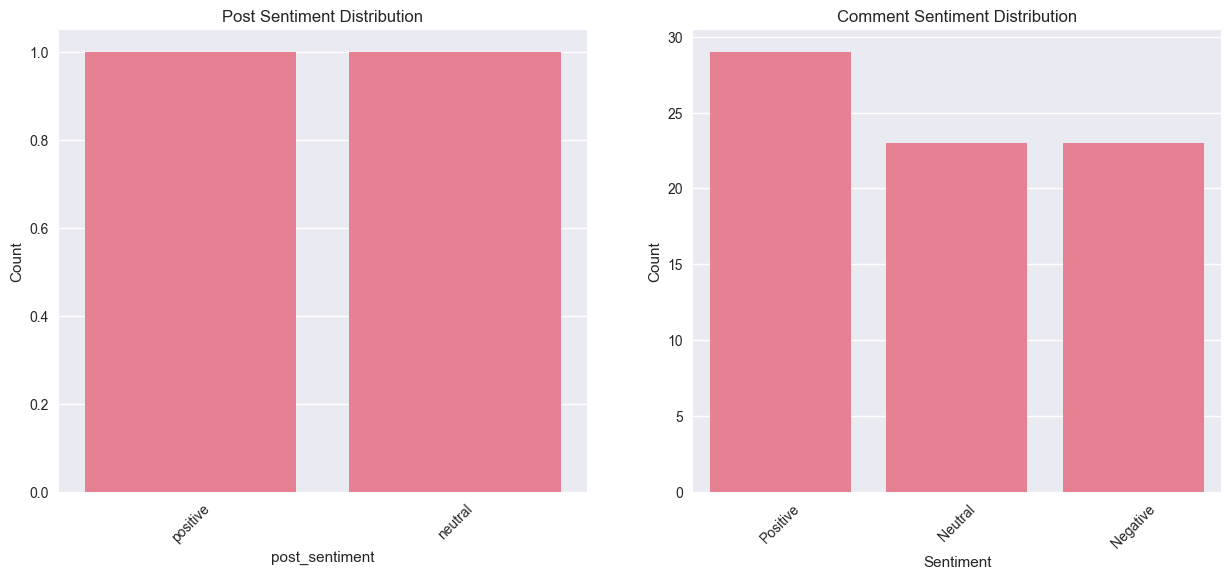

<Figure size 1500x800 with 0 Axes>

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
import json

class NumpyEncoder(json.JSONEncoder):
    """Custom encoder for numpy data types"""
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                          np.int16, np.int32, np.int64, np.uint8,
                          np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

class SentimentVisualizer:
    def __init__(self, df):
        """Initialize with path to sentiment analysis CSV file."""
        self.df = df
        
        # Set style
        plt.style.use('seaborn-v0_8')
        sns.set_palette("husl")
        
    def create_sentiment_distribution(self, save_path='figures'):
        """Create sentiment distribution plots."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Posts sentiment distribution
        posts_sentiment_counts = self.df['post_sentiment'].value_counts()
        sns.barplot(x=posts_sentiment_counts.index, y=posts_sentiment_counts.values, ax=ax1)
        ax1.set_title('Post Sentiment Distribution')
        ax1.set_ylabel('Count')
        ax1.tick_params(axis='x', rotation=45)
        
        # Comments distribution (positive/neutral/negative)
        comment_counts = pd.DataFrame({
            'Sentiment': ['Positive', 'Neutral', 'Negative'],
            'Count': [
                self.df['positive_comments'].sum(),
                self.df['neutral_comments'].sum(),
                self.df['negative_comments'].sum()
            ]
        })
        sns.barplot(data=comment_counts, x='Sentiment', y='Count', ax=ax2)
        ax2.set_title('Comment Sentiment Distribution')
        ax2.set_ylabel('Count')
        ax2.tick_params(axis='x', rotation=45)
        
        plt.figure(figsize=(15, 6))  # Create new figure with larger size
        plt.subplots_adjust(bottom=0.2)  # Adjust bottom margin
        # plt.savefig(f'{save_path}/sentiment_distribution.png', bbox_inches='tight', dpi=300)
        plt.close()
        
    def create_compound_score_plot(self, save_path='figures'):
        """Create compound score visualization."""
        plt.figure(figsize=(15, 8))  # Increased figure size
        
        # Create bar plot of compound scores
        bars = plt.bar(range(len(self.df)), self.df['sentiment_compound'])
        
        # Color bars based on sentiment
        colors = {'positive': 'green', 'neutral': 'gray', 'negative': 'red'}
        for bar, sentiment in zip(bars, self.df['post_sentiment']):
            bar.set_color(colors[sentiment])
        
        plt.title('Sentiment Compound Scores by Post', pad=20)
        plt.xlabel('Posts')
        plt.ylabel('Compound Score')
        
        # Rotate and align the tick labels so they look better
        plt.xticks(range(len(self.df)), 
                  self.df['title'].str[:30] + '...', 
                  rotation=45,
                  ha='right')
        
        # Add horizontal line at y=0
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.2)
        
        # Adjust layout
        plt.subplots_adjust(bottom=0.2)
        
        # plt.savefig(f'{save_path}/compound_scores.png', bbox_inches='tight', dpi=300)
        plt.close()
        
    def create_subreddit_analysis(self, save_path='figures'):
        """Create subreddit-level sentiment analysis."""
        if self.df['subreddit'].nunique() > 1:
            plt.figure(figsize=(12, 8))
            
            subreddit_sentiment = pd.crosstab(self.df['subreddit'], self.df['post_sentiment'])
            subreddit_sentiment.plot(kind='bar', stacked=True)
            
            plt.title('Sentiment Distribution by Subreddit')
            plt.xlabel('Subreddit')
            plt.ylabel('Count')
            plt.legend(title='Sentiment')
            plt.xticks(rotation=45, ha='right')
            
            plt.subplots_adjust(bottom=0.2)
            # plt.savefig(f'{save_path}/subreddit_sentiment.png', bbox_inches='tight', dpi=300)
            plt.close()
    
    def create_comment_analysis(self, save_path='figures'):
        """Create visualization of comments analysis."""
        plt.figure(figsize=(15, 8))
        
        # Prepare data
        comments_data = self.df[['title', 'positive_comments', 'neutral_comments', 'negative_comments']]
        comments_data = comments_data.set_index('title')
        
        # Create stacked bar chart
        ax = comments_data.plot(kind='bar', stacked=True)
        
        plt.title('Comment Sentiment Distribution by Post')
        plt.xlabel('Posts')
        plt.ylabel('Number of Comments')
        plt.legend(title='Comment Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Rotate and align the tick labels so they look better
        plt.xticks(rotation=45, ha='right')
        
        # Adjust layout to prevent label cutoff
        plt.subplots_adjust(bottom=0.2, right=0.85)
        # plt.savefig(f'{save_path}/comments_analysis.png', bbox_inches='tight', dpi=300)
        plt.close()
        
    def create_all_visualizations(self, save_path='figures'):
        """Create all visualizations."""
        # Create output directory if it doesn't exist
        # Path(save_path).mkdir(exist_ok=True)
        
        self.create_sentiment_distribution(save_path)
        self.create_compound_score_plot(save_path)
        self.create_subreddit_analysis(save_path)
        self.create_comment_analysis(save_path)
        
        # Create summary statistics with native Python types
        summary = {
            'total_posts': int(len(self.df)),
            'sentiment_distribution': {
                k: int(v) for k, v in self.df['post_sentiment'].value_counts().to_dict().items()
            },
            'comment_statistics': {
                'total_comments': int(self.df['comment_count'].sum()),
                'positive_comments': int(self.df['positive_comments'].sum()),
                'neutral_comments': int(self.df['neutral_comments'].sum()),
                'negative_comments': int(self.df['negative_comments'].sum())
            },
            'subreddits': self.df['subreddit'].unique().tolist(),
            'average_compound_score': float(self.df['sentiment_compound'].mean())
        }
        
        # Save summary to JSON using custom encoder
        # with open(f'{save_path}/analysis_summary.json', 'w', encoding='utf-8') as f:
        #     json.dump(summary, f, indent=2, cls=NumpyEncoder)
        
        return summary

def main():
    try:
        # Initialize visualizer
        visualizer = SentimentVisualizer(
            df=process_data()
        )
        
        # Create all visualizations
        result = visualizer.create_all_visualizations()
        
        # print("Visualizations have been created in the 'figures' directory!")
        # print("The following files were generated:")
        # print("- sentiment_distribution.png")
        # print("- compound_scores.png")
        # print("- subreddit_sentiment.png")
        # print("- comments_analysis.png")
        # print("- analysis_summary.json")
        print(result)   
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()